In [1]:
#################################
# 1. IMPORTS & CONFIG
#################################
import os
import gc
import cv2
import torch
import random
import numpy as np
import pandas as pd

from glob import glob
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from google.colab import drive
from sklearn.metrics import f1_score



In [2]:
#################################
# 2. BASIC SETTINGS
#################################
class CFG:
    seed = 42
    n_splits = 2       # Basic K-Fold
    epochs = 5
    train_bs = 32
    valid_bs = 23
    lr = 1e-3
    num_workers = 2
    img_size = 224
    device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

In [3]:
#################################
# 3. LOAD DATA
#################################
train_df = pd.read_csv("/content/drive/MyDrive/open-data-day-2025-dates-types-classification/train_labels.csv")
train_df["path"] = "/content/drive/MyDrive/open-data-day-2025-dates-types-classification/train/" + train_df["filename"]
train_df.drop("filename", axis=1, inplace=True)
train_df = train_df[["path","label"]]

test_paths = glob("/content/drive/MyDrive/open-data-day-2025-dates-types-classification/test/*")
test_df = pd.DataFrame({"path": test_paths})

print("Train Shape:", train_df.shape)
print("Test  Shape:", test_df.shape)
print(train_df.head())

# Map string labels to integer indices
label_mapping = {
    "Ajwa":        0,
    "Medjool":     1,
    "Meneifi":     2,
    "Nabtat Ali":  3,
    "Shaishe":     4,
    "Sokari":      5,
    "Sugaey":      6
}
train_df["label_idx"] = train_df["label"].map(label_mapping)

Train Shape: (432, 2)
Test  Shape: (126, 1)
                                                path label
0  /content/drive/MyDrive/open-data-day-2025-date...  Ajwa
1  /content/drive/MyDrive/open-data-day-2025-date...  Ajwa
2  /content/drive/MyDrive/open-data-day-2025-date...  Ajwa
3  /content/drive/MyDrive/open-data-day-2025-date...  Ajwa
4  /content/drive/MyDrive/open-data-day-2025-date...  Ajwa


In [4]:
train_df["fold"] = -1
kf = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

for fold_number, (tr_idx, val_idx) in enumerate(kf.split(train_df)):
    train_df.loc[val_idx, "fold"] = fold_number

print(train_df.groupby("fold").size())

fold
0    216
1    216
dtype: int64


In [5]:
#################################
# 5. DATASET & TRANSFORMS
#################################
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(CFG.img_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=10, shear=5),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

valid_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])



In [6]:
#################################
# Old Dataset class
#################################
class DatesDataset(Dataset):
    def __init__(self, df, mode="train", transforms=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = row["path"]
        label_idx = row["label_idx"] if "label_idx" in row else None

        # Read image (BGR), then convert to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

        if self.mode != "test":
            return image, label_idx
        else:
            return image

In [7]:
class DatesDataset(Dataset):
    def __init__(self, df, mode="train", transforms=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = row["path"]
        label_idx = row["label_idx"] if "label_idx" in row else None

        # Read the image (BGR format) using OpenCV
        image = cv2.imread(image_path)

        # ✅ Check if the image is None (File Missing or Corrupt)
        if image is None:
            print(f"⚠️ Warning: Failed to load image at {image_path}")
            # Return a blank image or handle the error gracefully
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Black image placeholder

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms (if any)
        if self.transforms:
            image = self.transforms(image)

        if self.mode == "test":
            return image
        else:
            return image, label_idx



#################################
# 6. MODEL DEFINITION (EffNet-B0)
#################################
# We'll modify the final layer for the number of classes we have (7).
def get_model(num_classes=7, pretrained=True):
    model = torchvision.models.efficientnet_b0(pretrained=pretrained)
    model.classifier[1] = nn.Linear(1280, num_classes)
    return model

In [14]:
#################################
# efficientnet_b0
#################################
class DateClassifier(nn.Module):
    def __init__(self, num_classes=7 , pretrained=True):
        super(DateClassifier, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=pretrained)
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 512),
            nn.BatchNorm1d(512),  # Batch Normalization added here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes),  # Batch Normalization added here
        )

    def forward(self, x):
        return self.model(x)


In [9]:
#################################
# CoCa
#################################
class DateClassifier(nn.Module):
    def __init__(self, num_classes=7 , pretrained=True):
        super(DateClassifier, self).__init__()
        self.model = coca(pretrained=pretrained)  # Assuming 'coca' function/class exists
        # Get the number of in_features for the classifier head
        in_features = self.model.classifier[1].in_features  # Adjust based on CoCa's structure if needed
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [15]:
#################################
# 6. TRAINING FUNCTION
#################################
def train_fn(train_loader, model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(CFG.device), labels.to(CFG.device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    return total_loss / len(train_loader), train_acc

In [16]:
#################################
# 7. VALIDATION FUNCTION
#################################
def validate_fn(valid_loader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images, labels = images.to(CFG.device), labels.to(CFG.device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(valid_loader), val_acc, val_f1


from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def get_model(num_classes=7, pretrained=True):
    if pretrained:
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Pretrained weights
    else:
        weights = None  # No pretrained weights

    model = efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model


In [17]:
#################################
# 7. TRAIN & VALID FUNCTIONS
#################################
def train_one_epoch(model, optimizer, dataloader, device, criterion):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    epoch_loss = total_loss / len(dataloader.dataset)
    return epoch_loss

def valid_one_epoch(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = total_loss / len(dataloader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

In [18]:
#################################
# 8. TRAINING LOOP
#################################
for fold in range(CFG.n_splits):
    print(f"Training Fold {fold+1}/{CFG.n_splits}")

    train_data = train_df[train_df.fold != fold]
    valid_data = train_df[train_df.fold == fold]

    train_dataset = DatesDataset(train_data, transforms=train_transform)
    valid_dataset = DatesDataset(valid_data, transforms=valid_transform)

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers)

    model = DateClassifier().to(CFG.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.epochs)

    best_f1 = 0
    for epoch in range(CFG.epochs):

        train_loss, train_acc = train_fn(train_loader, model, criterion, optimizer, scheduler)
        val_loss, val_acc, val_f1 = validate_fn(valid_loader, model, criterion)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            save_path = f"effb0_fold_{fold}.pth"
            print("Saved best model!")
            torch.save(model.state_dict(), save_path)
            print(f"  --> Model saved to {save_path}")

    print(f"Fold {fold} best accuracy: {best_f1:.4f}\n")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Training Fold 1/2


100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 
100%|██████████| 10/10 [01:25<00:00,  8.60s/it]


Epoch 1: Train Loss: 2.1213, Train Acc: 0.1759 | Val Loss: 1.9063, Val Acc: 0.2500, Val F1: 0.1983
Saved best model!
  --> Model saved to effb0_fold_0.pth


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Epoch 2: Train Loss: 1.8820, Train Acc: 0.2917 | Val Loss: 1.7679, Val Acc: 0.3889, Val F1: 0.3582
Saved best model!
  --> Model saved to effb0_fold_0.pth


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


Epoch 3: Train Loss: 1.6365, Train Acc: 0.3981 | Val Loss: 1.6351, Val Acc: 0.4769, Val F1: 0.4334
Saved best model!
  --> Model saved to effb0_fold_0.pth


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Epoch 4: Train Loss: 1.5130, Train Acc: 0.4583 | Val Loss: 1.4698, Val Acc: 0.5972, Val F1: 0.5642
Saved best model!
  --> Model saved to effb0_fold_0.pth


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 5: Train Loss: 1.2481, Train Acc: 0.5880 | Val Loss: 1.3144, Val Acc: 0.6065, Val F1: 0.5639
Fold 0 best accuracy: 0.5642

Training Fold 2/2


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Epoch 1: Train Loss: 2.2733, Train Acc: 0.1667 | Val Loss: 1.9188, Val Acc: 0.2500, Val F1: 0.1788
Saved best model!
  --> Model saved to effb0_fold_1.pth


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


Epoch 2: Train Loss: 1.9621, Train Acc: 0.2824 | Val Loss: 1.7527, Val Acc: 0.4028, Val F1: 0.3578
Saved best model!
  --> Model saved to effb0_fold_1.pth


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


Epoch 3: Train Loss: 1.6399, Train Acc: 0.3657 | Val Loss: 1.6457, Val Acc: 0.5787, Val F1: 0.5657
Saved best model!
  --> Model saved to effb0_fold_1.pth


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


Epoch 4: Train Loss: 1.3468, Train Acc: 0.4907 | Val Loss: 1.4775, Val Acc: 0.6111, Val F1: 0.5933
Saved best model!
  --> Model saved to effb0_fold_1.pth


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

Epoch 5: Train Loss: 1.2412, Train Acc: 0.5972 | Val Loss: 1.3432, Val Acc: 0.5972, Val F1: 0.5889
Fold 1 best accuracy: 0.5933



#################################
# 8. K-FOLD TRAINING LOOP
#################################
def run_training(fold):
    print(f"========== Fold: {fold} ==========")

    # Split
    train_data = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_data = train_df[train_df["fold"] == fold].reset_index(drop=True)

    # Datasets
    train_dataset = DatesDataset(train_data, mode="train", transforms=train_transforms)
    valid_dataset = DatesDataset(valid_data, mode="valid", transforms=valid_transforms)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                              shuffle=True, num_workers=CFG.num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs,
                              shuffle=False, num_workers=CFG.num_workers)

    # Model, Optimizer, Loss
    model = get_model(num_classes=len(label_mapping), pretrained=True)
    model.to(CFG.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

    best_acc = 0.0
    for epoch in range(CFG.epochs):
        print(f"Fold {fold} | Epoch {epoch+1}/{CFG.epochs}")
        
        train_loss = train_one_epoch(model, optimizer, train_loader, CFG.device, criterion)
        valid_loss, valid_acc = valid_one_epoch(model, valid_loader, CFG.device, criterion)

        print(f"  [Train Loss: {train_loss:.4f}]  [Valid Loss: {valid_loss:.4f}]  [Valid Acc: {valid_acc:.4f}]")

        # Save best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            save_path = f"effb0_fold_{fold}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"  --> Model saved to {save_path}")
    
    print(f"Fold {fold} best accuracy: {best_acc:.4f}\n")

In [ ]:
#for fold in range(CFG.n_splits):
#    run_training(fold)

In [19]:
#################################
# 10. INFERENCE & SUBMISSION
#################################
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(dataloader, desc="Inferring", leave=False):
            imgs = imgs.to(device)
            outputs = model(imgs)
            # We'll use softmax for probabilities
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            preds.append(probabilities)
    return np.concatenate(preds, axis=0)

def run_inference_on_test():
    # We prepare the test dataset
    test_dataset = DatesDataset(test_df, mode="test", transforms=valid_transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs,
                             shuffle=False, num_workers=CFG.num_workers)

    # Load each fold's best model, do predictions for each, average all models predictions
    fold_preds = []
    for f_ in range(CFG.n_splits):
        model_path = f"effb0_fold_{f_}.pth"
        if not os.path.exists(model_path):
            print(f"Warning: no model found at {model_path}, skipping this fold.")
            continue

        model = DateClassifier(num_classes=len(label_mapping), pretrained=False).to(CFG.device)
        model.load_state_dict(torch.load(model_path, map_location=CFG.device))
        model.to(CFG.device)

        preds = inference_fn(model, test_loader, CFG.device)
        fold_preds.append(preds)

        # cleanup
        del model
        gc.collect()
        torch.cuda.empty_cache()

    # Average predictions across folds
    final_preds = np.mean(fold_preds, axis=0)  # shape = [len(test), #classes]
    class_indices = np.argmax(final_preds, axis=1)

    inv_map = {v: k for k, v in label_mapping.items()}
    final_labels = [inv_map[i] for i in class_indices]

    # Create submission
    submission = pd.DataFrame({
        "filename": test_df["path"].apply(os.path.basename),
        "label": final_labels
    })
    submission.to_csv("submission.csv", index=False)
    print("Saved submission.csv!")
    print(submission.head())

In [20]:
run_inference_on_test()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Saved submission.csv!
       filename    label
0  1beec184.jpg     Ajwa
1  1cc1867e.jpg     Ajwa
2  0c3e33ce.jpg  Meneifi
3  0be87456.jpg  Meneifi
4  0e3f2e72.jpg   Sugaey


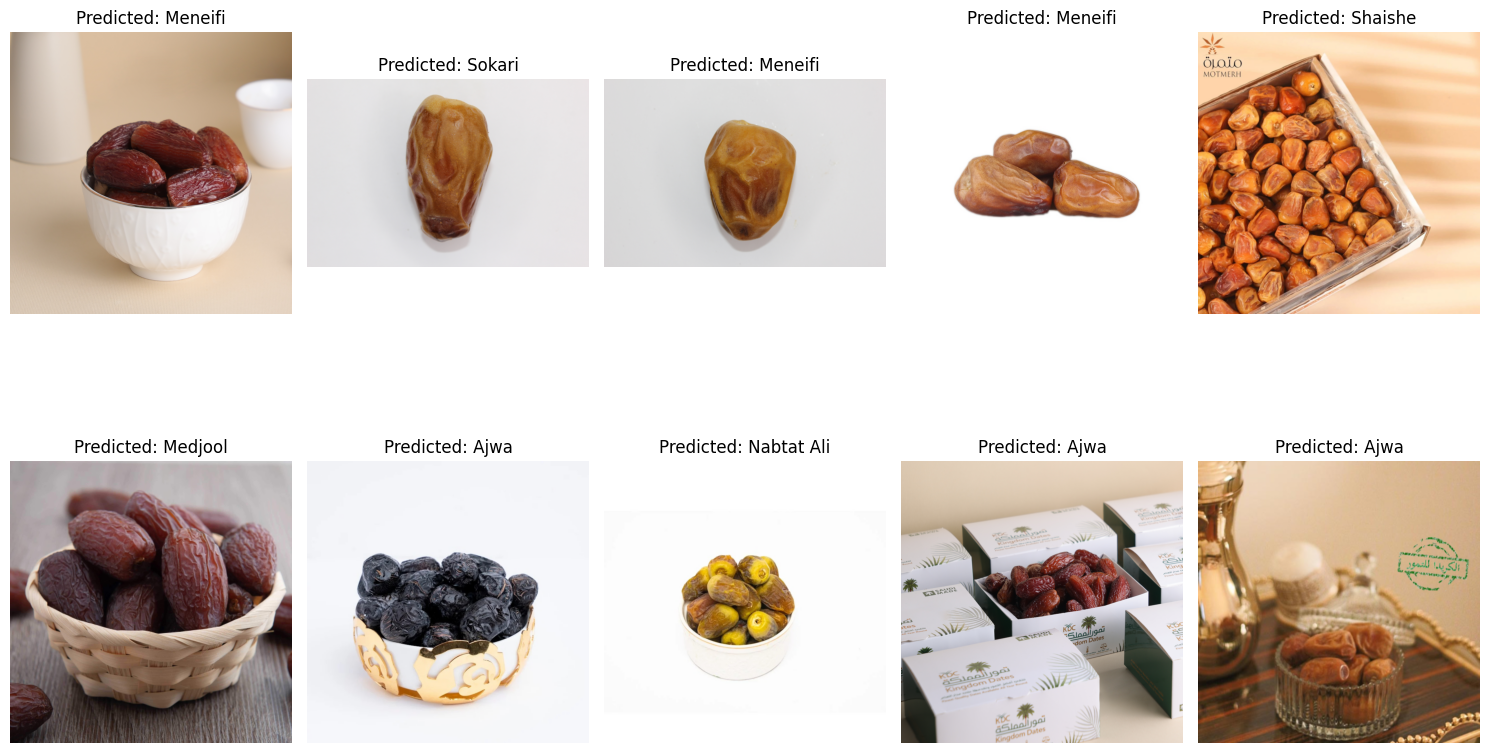

In [21]:
#################################
# 11. DISPLAY 10 RANDOM IAMGES
#################################
import matplotlib.pyplot as plt
import random

# Assuming 'submission.csv' and image paths are correctly set up
submission_df = pd.read_csv("submission.csv")

# Randomly select 10 image indices
random_indices = random.sample(range(len(submission_df)), 10)

plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, idx in enumerate(random_indices):
    image_path = os.path.join("/content/drive/MyDrive/open-data-day-2025-dates-types-classification/test", submission_df.loc[idx, 'filename'])
    predicted_label = submission_df.loc[idx, 'label']

    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 5, i + 1)  # Adjust subplot layout as needed
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')

    except Exception as e:
        print(f"Error loading or displaying image at {image_path}: {e}")
        # Handle the error, e.g., display a placeholder image or skip the image


plt.tight_layout()
plt.show()


In [22]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [33]:
model = DateClassifier(num_classes=7)
model.load_state_dict(torch.load("efficientnet_datefruit.pth", map_location="cpu"))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'efficientnet_datefruit.pth'

In [36]:
model = DateClassifier(num_classes=7)
# Assuming the model is saved in a specific path on your drive
model_path = "/content/effb0_fold_1.pth"  # Update with your actual path

# Check if the file exists
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
else:
    print(f"Error: Model file not found at {model_path}")

In [43]:
class_names = ['Barhi', 'Deglet', 'Khalas', 'Medjool', 'Sukkary', 'Zahidi', 'Other']  # example

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet norms
])


In [44]:
def predict(img):
    img = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]


In [45]:
import gradio as gr
gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="label",
    title="Date Fruit Classifier",
    description="Upload an image of a date fruit and the model will predict its type."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://71ecc628e42dd7b464.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
